In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

data_kgb_l = nested_dict(5, list)
data_kgb_s = nested_dict(5, list)

In [22]:
import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

# kevolution data

In [23]:
from configparser import ConfigParser
from itertools import chain

path_back= "../../PhD_project/Farbods_simulations/mu_paper/"


backgrounds =  np.loadtxt(path_back+'file_background.dat').T
#rho_m_kev = backgrounds[10][-1] + backgrounds[11][-1]
#rho_DE_kev = backgrounds[9][-1] 

f_rho_fld = interp1d(backgrounds[2], backgrounds[9], kind='cubic')
f_rho_cdm = interp1d(backgrounds[2], backgrounds[10], kind='cubic')
f_rho_b = interp1d(backgrounds[2], backgrounds[11], kind='cubic')

def rho_m_kev(val):
    return f_rho_cdm(1/(1+val))+f_rho_b(1/(1+val))

def rho_DE_kev(val):
    return f_rho_fld(1/(1+val))


path = "../../PhD_project/Farbods_simulations/mu_paper/Full_simulations_20March2019-1280Mpc"
path_3840 = path + "/1280-cs_e7-w09-Kevolution/output/"

Pk_corr = []
Pk_delta = []
Pk_delta_kess = []
mu_3840_e7 = []
mu_corr_3840_e7 = []
mu_test = []
z_kess = []

for root, subdirs, files in os.walk(path_3840):
    for filename in files:
        if filename.endswith('delta.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta.append(file_path)
            Pk_delta.sort(reverse=True)
    for filename in files:
        if filename.endswith('delta_kess.dat'):
            file_path = os.path.join(root, filename)
            Pk_delta_kess.append(file_path)
            Pk_delta_kess.sort(reverse=True)
    for filename in files:
        if filename.endswith("deltakess_deltam.dat"):
            file_path = os.path.join(root, filename)
            Pk_corr.append(file_path)
            Pk_corr.sort(reverse=True)

for i in range (len(Pk_delta)):
    
    k_3840, PP_m = np.loadtxt(Pk_delta[i], usecols=[0,1], unpack = True)
    k_3840, PP_DE = np.loadtxt(Pk_delta_kess[i], usecols=[0,1], unpack = True)
    k_3840, PP_corr = np.loadtxt(Pk_corr[i], usecols=[0, 1], unpack=True)
    
    with open(Pk_delta[i], 'r') as file:
    # Loop through each line in the file
        for line in file:
            # Check if the line starts with "# z ="
            if line.startswith("# redshift z="):
                # Extract the value of z from the line
                z_value = float(line.split('=')[1].strip())
                z_kess.append(z_value)
    
    mu_3840_e7.append(1 + (rho_DE_kev(z_value)*np.sqrt(PP_DE))/(rho_m_kev(z_value)*np.sqrt(PP_m)))   
    
    mu_corr_3840_e7.append(np.sqrt(
    ((rho_DE_kev(z_value) ** 2) * PP_DE + (rho_m_kev(z_value) ** 2) * PP_m
        + 2 * (rho_m_kev(z_value) * rho_DE_kev(z_value)) * PP_corr)
    / ((rho_m_kev(z_value) ** 2) * PP_m)
    ))
    
    mu_test.append(np.sqrt(
    ((rho_DE_kev(z_value) ** 2) * PP_DE + (rho_m_kev(z_value) ** 2) * PP_m
        + 2 * (rho_m_kev(z_value) * rho_DE_kev(z_value)) * np.sqrt(PP_m*PP_DE))
    / ((rho_m_kev(z_value) ** 2) * PP_m)
    ))
    
       

# KGB data

In [27]:
from configparser import ConfigParser
from itertools import chain
parser = ConfigParser()
############################################################################################
#                                      KGB-evolution loading data

# if you want to use 1 or 2 simulation for resolution cover
number_sim = 1

# 1 is with comparison with hiclass using the same redshifts as KGB and 2 is comparison with kevolution
# picking up commun redshifts
comparison = 1

# for a single simulation
folder_name_kgb = './output'    

# for linking two simulations
folder_name_kgb_l = './output'   
folder_name_kgb_s = './output'

if number_sim ==2:
    folder_name_kgb = folder_name_kgb_s
###############################################################################
#                                            single simulation

with open(f"./../{folder_name_kgb}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)


boxsize = float(parser.get("top", "boxsize"))
Ngrid = float(parser.get("top", "Ngrid"))

k_nyq = np.pi*Ngrid/boxsize
k_nyq_single_rounded = "{:.2f}".format(k_nyq)
    
###############################################################################
#                                            Large boxsize

with open(f"./../{folder_name_kgb_l}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

boxsize_l = float(parser.get("top", "boxsize"))

##############################################################################
#                                            Small boxsize

with open(f"./../{folder_name_kgb_s}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

boxsize_s = float(parser.get("top", "boxsize"))
Ngrid_s = float(parser.get("top", "Ngrid"))

k_nyq_s = np.pi*Ngrid_s/boxsize_s
k_nyq_rounded = "{:.2f}".format(k_nyq_s)

#######################################################################################

with open(f"./../{folder_name_kgb}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

h = float(parser.get("top", "h"))
Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))
#m_ncdm = float(parser.get("top", "m_ncdm"))
n_s = float(parser.get("top", "n_s"))
A_s = float(parser.get("top", "A_s"))

gravity_model = (parser.get("top", "gravity_model"))
gravity_model_latex = gravity_model.replace("_", r"\_")

#Omega_smg = float(parser.get("top", "Omega_smg"))
Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
Omega_fld = float(parser.get("top", "Omega_fld"))

# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(',')



if len(parameters_smg_list) < 2:
    raise ValueError("parameters_smg must contain at least two values: alpha_k and alpha_b.")

# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())


# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')

Omega_smg = float(expansion_smg_list[0].strip())
w0 = float(expansion_smg_list[1].strip())
wa = float(expansion_smg_list[2].strip())

# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split('e')
    exponent = exponent.lstrip('+').lstrip('0') or '0'
    return f"{mantissa} \\times 10^{{{exponent}}}"

# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# reading the redshifts

z_kgb = []

with open(f'./../{folder_name_kgb}/file_settings_used.ini', 'r') as f:
    for line in f:
        if line.startswith('Pk redshifts'):
            # Extract the part after '=' and split by commas
            redshifts_string = line.split('=')[1].split('#')[0].strip()  # Remove comments after #
            z_kgb = [float(x.strip()) for x in redshifts_string.split(',')]  # Parse as floats
            
with open(f"./../{folder_name_kgb}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

nKe_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))

z = z_kgb
########################################################################################################
#                                             redshifts

if comparison == 1:    #KGB-evolution hiclass comparison
    z_plot = z_kgb
elif comparison == 2:  #KGB-evolution k-evoltion comparison
    z_commun = sorted(set(z_kgb) & set(z_kess), reverse=True)            
    z_plot = z_commun



# Linking simulation 

In [29]:
###########################################################
#                         for single simulation

mu = [None] * len(z)
mu_corr =[None] * len(z)

###########################################################
#                         for double simulation
mu_l = [None] * len(z)
mu_corr_l =[None] * len(z)

mu_s = [None] * len(z)
mu_corr_s =[None] * len(z)

mu_fin = [None] * len(z)


backgrounds =  np.loadtxt("../"+folder_name_kgb+'/file_background.dat').T

f_rho_fld = interp1d(backgrounds[2], backgrounds[13], kind='cubic')
f_rho_cdm = interp1d(backgrounds[2], backgrounds[14], kind='cubic')
f_rho_b = interp1d(backgrounds[2], backgrounds[15], kind='cubic')
cs2_kgb = backgrounds[10]


def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split('e')
    exponent = str(int(exponent))  # Convert to integer to remove leading zeros
    return f"{mantissa} \\times 10^{{{exponent}}}"

cs2_kgb_latex1 = format_scientific_latex(cs2_kgb[0])
cs2_kgb_latex2 = format_scientific_latex(cs2_kgb[-1])

def rho_m_kev(val):
    return f_rho_cdm(1/(1+val))+f_rho_b(1/(1+val))

def rho_DE_kev(val):
    return f_rho_fld(1/(1+val))

for zind, zval in list(enumerate(z)):
    
####################################################################################################### 
#                                            For single simulation  

    file_index = str(zind).zfill(2)
    
    data_kgb["kgb"]["delta_kess"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_delta_kess.dat"
    )
    data_kgb["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_delta.dat"
    )
    data_kgb["kgb"]["deltakess_deltam"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb}/pk_0{file_index}_deltakess_deltam.dat"
    )
    
    k = data_kgb["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 0]
    
    pk_kgb_delta_kess = data_kgb["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 1]

    pk_kgb_delta = data_kgb["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_deltakess_deltam = data_kgb["kgb"]["deltakess_deltam"]["z=" + str(z[zind])][:, 1]
    
    
    mu[zind] = 1 + (rho_DE_kev(zval)*np.sqrt(pk_kgb_delta_kess))/(rho_m_kev(zval)*np.sqrt(pk_kgb_delta))
    
    mu_corr[zind] = np.sqrt(
    ((rho_DE_kev(zval) ** 2) * pk_kgb_delta_kess + (rho_m_kev(zval) ** 2) * pk_kgb_delta
        + 2 * (rho_m_kev(zval) * rho_DE_kev(zval)) * pk_kgb_deltakess_deltam)
    / ((rho_m_kev(zval) ** 2) * pk_kgb_delta)
    )
    
    ind_nyq       = [i for i, v in enumerate(k) if k_nyq < v ][0]
    kk_kgb        = k[:ind_nyq]
    mu[zind]      = mu[zind][:ind_nyq]
    mu_corr[zind] = mu_corr[zind][:ind_nyq]
       
########################################################################################################    
#                                            For double simulation
#                                               large boxsize

    file_index = str(zind).zfill(2)
    
    data_kgb_l["kgb"]["delta_kess"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_l}/pk_0{file_index}_delta_kess.dat"
    )
    data_kgb_l["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_l}/pk_0{file_index}_delta.dat"
    )
    data_kgb_l["kgb"]["deltakess_deltam"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_l}/pk_0{file_index}_deltakess_deltam.dat"
    )
    
    k_l = data_kgb_l["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 0]
    
    pk_kgb_delta_kess_l = data_kgb_l["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 1]

    pk_kgb_delta_l = data_kgb_l["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_deltakess_deltam_l = data_kgb_l["kgb"]["deltakess_deltam"]["z=" + str(z[zind])][:, 1]
    
    
    mu_l[zind] = 1 + (rho_DE_kev(zval)*np.sqrt(pk_kgb_delta_kess_l))/(rho_m_kev(zval)*np.sqrt(pk_kgb_delta_l))
    
    mu_corr_l[zind] = np.sqrt(
    ((rho_DE_kev(zval) ** 2) * pk_kgb_delta_kess_l + (rho_m_kev(zval) ** 2) * pk_kgb_delta_l
        + 2 * (rho_m_kev(zval) * rho_DE_kev(zval)) * pk_kgb_deltakess_deltam_l)
    / ((rho_m_kev(zval) ** 2) * pk_kgb_delta_l)
    )
        
######################################################################################################  
#                                            For double simulation
#                                               small boxsize

    data_kgb_s["kgb"]["delta_kess"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_s}/pk_0{file_index}_delta_kess.dat"
    )
    data_kgb_s["kgb"]["delta_kess"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_s}/pk_0{file_index}_delta_kess.dat"
    )
    data_kgb_s["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_s}/pk_0{file_index}_delta.dat"
    )
    data_kgb_s["kgb"]["deltakess_deltam"]["z=" + str(z[zind])] = np.loadtxt(
        f"./../{folder_name_kgb_s}/pk_0{file_index}_deltakess_deltam.dat"
    )
    
    k_s = data_kgb_s["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 0]
    
    pk_kgb_delta_kess_s = data_kgb_s["kgb"]["delta_kess"]["z=" + str(z[zind])][:, 1]

    pk_kgb_delta_s = data_kgb_s["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_deltakess_deltam_s = data_kgb_s["kgb"]["deltakess_deltam"]["z=" + str(z[zind])][:, 1]
    
    
    mu_s[zind] = 1 + (rho_DE_kev(zval)*np.sqrt(pk_kgb_delta_kess_s))/(rho_m_kev(zval)*np.sqrt(pk_kgb_delta_s))
    
    mu_corr_s[zind] = np.sqrt(
    ((rho_DE_kev(zval) ** 2) * pk_kgb_delta_kess_s + (rho_m_kev(zval) ** 2) * pk_kgb_delta_s
        + 2 * (rho_m_kev(zval) * rho_DE_kev(zval)) * pk_kgb_deltakess_deltam_s)
    / ((rho_m_kev(zval) ** 2) * pk_kgb_delta_s)
    )
    
    
#############################################################################    
#                                            For double simulation
#                                            combining the results

    ind_l = [i for i, v in enumerate(k_l) if 0.22 < v ][0]
    ind_s = [i for i, v in enumerate(k_s) if 0.22 < v ][0]
    ind_nyq = [i for i, v in enumerate(k_s) if k_nyq_s < v ][0]


    kk_1 = k_l[:ind_l]
    kk_2 = k_s[ind_s:ind_nyq]

    mu_1 = mu_l[zind][:ind_l]
    mu_2 = mu_s[zind][ind_s:ind_nyq]

    kk_fin = [*kk_1,*kk_2]
    mu_fin[zind] = [*mu_1,*mu_2]

TypeError: unhashable type: 'slice'

In [12]:
if number_sim  == 1:    #KGB-evolution single simulation
    kk = kk_kgb
elif number_sim  == 2:  #KGB-evolution double simulations
    kk = kk_fin
else:
    kk = np.logspace(-2.5, np.log10(10), 1000)  # k in h/Mpc

NameError: name 'kk_kgb' is not defined

In [34]:
alpha_K_hat = 3e+06
alpha_B_hat = 0.08

# hiclass KGB

In [13]:
kk = np.logspace(-3.5,np.log10(10),1000) # k in h/Mpc

def a(x):
    return 1/(1+x)

mu_kgb_phi = [[] for j in range(len(z))]
mu_kgb_delta = [[] for j in range(len(z))]


synchronous = {
    "Omega_smg": -1,
    "Omega_Lambda": 0,
    "Omega_fld": 0,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
    "tau_reio": 0.05430842,
    "gravity_model": gravity_model,
    #     "non linear": "Halofit",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": "w0wa",
    "expansion_smg": f"{Omega_smg},{w0},{wa}",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}


# storying alpha_K_hat, alpha_B_hat, and w0
expansion_smg = synchronous["expansion_smg"].split(",")
parameters_smg = synchronous["parameters_smg"].split(",")

w0 = float(expansion_smg[1])
alpha_K_hat = float(parameters_smg[0])
alpha_B_hat = float(parameters_smg[1])
gravity_model= synchronous["gravity_model"]


M_syn = Class()
M_syn.set(synchronous)

M_syn.compute()


h = M_syn.h()

As = synchronous["A_s"]
ns = synchronous["n_s"]


backgrounds = M_syn.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")


H0_squared = H(0) ** 2

Mpl2 = 1 / (3.0 * H0_squared)


Delta_rhoDE_kgb = [None] * len(z)

for zind, zi in enumerate(z):

    Hconf = a(zi) * H(zi)
    Hconf_prime = (a(zi) ** 2) * (H(zi) ** 2) + a(zi) * H_prime(zi)

    rho_m = rho_b(zi) + rho_cdm(zi)
    
    rho_excde = rho_tot(zi) - rho_smg(zi)

    rho_sum = rho_cdm(zi) + rho_b(zi) + rho_g(zi) + rho_ur(zi)

    #######################################################################################################
    #                                                 synchronous

    Transfers_syn = M_syn.get_transfer(zi)

    #############
    delta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_b"], kind="cubic"
    )
    theta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_cdm"], kind="cubic"
    )
    #############
    delta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_g"], kind="cubic"
    )
    theta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_g"], kind="cubic"
    )
    #############
    delta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_ur"], kind="cubic"
    )
    theta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_ur"], kind="cubic"
    )
    #############

    delta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_tot"], kind="cubic"
    )

    theta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_tot"], kind="cubic"
    )

    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")
    phi_prime_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["phi_prime"], kind="cubic"
    )
    psi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["psi"], kind="cubic")

    vx_smg = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["h_prime"], kind="cubic"
    )
    
    list_tmp = []

    for k in kk:

        ###################################################################################################
        #                                 delta_smg in Newtonian
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime =  psi_syn(k) - Hconf * alpha
              
        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime 
        zeta_newt = Hconf * pi_newt + pi_prime_newt - psi_syn(k)
        
        
        delta_smg_newt = (
            (Mpl2 / a(zi) ** 2)
            * (
                -alpha_B(zi) * Hconf * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(zi) * (Hconf**2) * psi_syn(k)
                - (3 * alpha_B(zi) + alpha_K(zi)) * (Hconf**2) * zeta_newt
                + 3 * alpha_B(zi) * Hconf * phi_prime_syn(k)
            )
            + (
                (Mpl2 * alpha_B(zi) / (a(zi) ** 2)) * (Hconf_prime - Hconf**2)
                + ((rho_smg(zi) + p_smg(zi)) / H0_squared)
            )
            * 3
            * Hconf
            * pi_newt
        ) / (rho_smg(zi) / H0_squared)
        ###################################################################################################
        #                                   delta_smg in Synchronous
        
        zeta_sync = Hconf * -vx_smg(k) - vx_prime_smg(k)

        delta_smg_sync = (
            (Mpl2 / a(zi) ** 2)
            * (
                -alpha_B(zi) * Hconf * ((k * h) ** 2) * -vx_smg(k)
                - (3 * alpha_B(zi) + alpha_K(zi)) * ((Hconf) ** 2) * zeta_sync
                + 3 * alpha_B(zi) * Hconf * eta_prime(k)
            )
            + (Mpl2 / a(zi) ** 2)
            * (
                (
                    alpha_B(zi) * Hconf_prime
                    - alpha_B(zi) * Hconf**2
                    + ((a(zi) ** 2 / Mpl2) * (rho_smg(zi) + p_smg(zi)) / H0_squared)
                )
                * 3
                * Hconf
                * -vx_smg(k)
            )
        ) / (rho_smg(zi) / H0_squared)


        ###################################################################################################

        Delta_cdm_sync = delta_cdm_syn(k)

        Delta_b_sync = delta_b_syn(k) + 3 * a(zi) * H(zi) * theta_b_syn(k) / (
            (k * h) ** 2
        )
        
        Delta_smg_comov = delta_smg_newt + alpha * rho_smg_prime(zi)/rho_smg(zi)
        
#         theta_smg_newt = (-vx_smg(k)+ alpha) * (k * h)**2
#         Delta_smg_newt = delta_smg_newt - 3 * a(zi) * H(zi) * (1 + w_fld) *  theta_smg_newt / ((k * h) ** 2)
        Delta_smg_newt = delta_smg_newt + alpha * rho_smg_prime(zi)/rho_smg(zi)
    
        list_tmp.append(rho_smg(zi) * Delta_smg_newt)
        
        theta_smg_sync = -vx_smg(k) * (k * h) ** 2
        Delta_smg_sync = delta_smg_sync - 3 * a(zi) * H(zi) * (1 + w0) * theta_smg_sync / ((k * h) ** 2)

        Delta_g_sync = delta_g_syn(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_g_syn(
            k
        ) / ((k * h) ** 2)

        Delta_ur_sync = delta_ur_syn(k) + 3 * a(zi) * H(zi) * (
            1 + 1 / 3
        ) * theta_ur_syn(k) / ((k * h) ** 2)

        
        rho_X_Delta_X = (
            rho_cdm(zi) * Delta_cdm_sync
            + rho_b(zi) * Delta_b_sync
            + rho_g(zi) * Delta_g_sync
            + rho_ur(zi) * Delta_ur_sync
        ) 


        k2_phi = -((k * h) ** 2) * phi_syn(k)

        ################################################################################################
        #                                   Poisson equation

        mu_kgb_delta[zind].append(1 - (rho_smg(zi) * Delta_smg_newt / (rho_X_Delta_X)))

        #         R = 3. * a(zi) * H(zi) * phi_prime_new(k) + 3. * ((a(zi) * H(zi))**2) * psi_new(k)

        mu_kgb_phi[zind].append((k2_phi) / (1.5 * a(zi) ** 2 * rho_X_Delta_X))

#         mu_full_poisson[zind].append(k2_phi/(rho_t_delta_t))

    Delta_rhoDE_kgb[zind] = list_tmp

In [14]:
backgrounds['c_s^2']

array([2.79972062e-06, 2.80007372e-06, 2.79998055e-06, ...,
       3.62381193e-07, 3.50678541e-07, 3.39695132e-07])

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

c = sns.color_palette("inferno", len(z_plot)).as_hex()

#############################################  background KGB-evolution   ###########################

backgrounds = np.loadtxt("../" + folder_name_kgb + "/file_background.dat").T
# rho_m_kev = backgrounds[10][-1] + backgrounds[11][-1]
# rho_DE_kev = backgrounds[9][-1]

f_rho_fld = interp1d(backgrounds[2], backgrounds[13], kind="cubic")
f_rho_cdm = interp1d(backgrounds[2], backgrounds[14], kind="cubic")
f_rho_b = interp1d(backgrounds[2], backgrounds[15], kind="cubic")


def rho_m_kev(val):
    return f_rho_cdm(1 / (1 + val)) + f_rho_b(1 / (1 + val))


def rho_DE_kev(val):
    return f_rho_fld(1 / (1 + val))


################################################ plot ###########################################

for zind, zval in list(enumerate(z_plot))[8::2]:

    ###############################################################################################
    #                                        hiclass KGB

    axs.plot(
        kk,
        mu_kgb_delta[zind],
        linewidth=2.0,
        linestyle="-",
        c=c[zind],
        label="$\mu^\mathrm{Como}_{\Delta}$ (hiclass) at $z = $"
        + "{0:.1f}".format(zval),
        alpha=0.5,
    )

    axs.plot(
            kk,
            mu_kgb_phi[zind],
            linewidth=2.,
            linestyle="-.",
            c = c[zind],
            label="$\mu^\mathrm{Como}_{\phi,\Delta}$ (hiclass) at $z =$ " + "{0:.1f}".format(zval),
        )

    ###############################################################################################
    #                              KGB-evolution single simulation

#     original_idx = z_kgb.index(z_plot[zind])

#     axs.plot(
#         kk,
#         mu_corr[original_idx],
#         "--",
#         c=c[zind],
#         label="$\mu^\mathrm{Newt}_{\delta}$ (KGB-evo), $z=$" + "{0:.1f}".format(zval),
#         linewidth=2.0,
#     )
    
    ###############################################################################################
    #                               KGB-evolution double simulation
    
#     original_idx = z_kgb.index(z_plot[zind])
    
#     axs.plot(
#         kk_fin,
#         mu_fin[zind],
#         "--",
#         c=c[zind],
#         label="$\mu^\mathrm{Newt}_{\delta}$ (KGB-evo), $z=$" + "{0:.1f}".format(zval),
#         linewidth=2.0,
#     )


    ###############################################################################################
    #                                         k-evolution

#     original_idx = z_kess.index(z_plot[zind])

#     axs.plot(
#         k_3840,
#         mu_corr_3840_e7[original_idx],
#         linewidth=2.3,
#         linestyle="-.",
#         c = c[zind],
#         label="$\mu^\mathrm{Newt}_\delta$ (kess) at z = " + "{0:.1f}".format(zval),
#     )


# axs.axvline(x=0.7, color='r', linestyle='--', linewidth=2)
axs.set_ylabel(r"$\mu(k,z)$", fontsize=20)
axs.set_xlabel(r"$k\,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)
# axs.axvline(x = 1.1, c = 'blue', linestyle = '--')


axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
# axs.set_yscale("log")

axs.grid()
# axs.legend(fontsize = 15)
axs.legend(
    fontsize=15,  # Font size
    loc="upper center",
    #bbox_to_anchor=(1.25, 1.02),
    bbox_to_anchor=(.5, -.1),
    ncol=2,
)



if number_sim == 1:
    boxsizes_str = rf"$\mathrm{{boxsizes}} = \mathrm{{{boxsize}}}$"
    k_Nyq_str    = rf"${{k}}_{{\mathrm{{Nyq}}}} = \mathrm{{{k_nyq_single_rounded}}}$"
elif number_sim == 2:
    boxsizes_str = rf"$\mathrm{{boxsizes}} = \mathrm{{{boxsize_l}}},\mathrm{{{boxsize_s}}}$"
    k_Nyq_str    = rf"${{k}}_{{\mathrm{{Nyq}}}} = \mathrm{{{k_nyq_rounded}}}$"
else:
    boxsizes_str = "" 
    k_Nyq_str    = ""


# axs.set_ylim([0.9, 1.05])
axs.set_title(
    r"$\textbf{Comparison of $\mu$: KGB-evolution vs k-evolution}$" + "\n"
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat_latex},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w0}}}$" +  "~,~~"
    rf"$\mathrm{{c_s^2}} = \mathrm{{{cs2_kgb_latex1}-{cs2_kgb_latex2}}}$"
    + "\n"
#     + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model_latex}}}$"
#     + "\n"
    + boxsizes_str
    + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$" + "~,~~"+
    k_Nyq_str
    + "\n"
    + rf"$\mathrm{{nKe\_numsteps}} = \mathrm{{{nKe_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=18,
)





plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

save_fig("mu_formulas")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving figure mu_formulas


ValueError: 
\textbf{Comparison of 
^
Unknown symbol: \textbf, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\textbf{Comparison of 
^
Unknown symbol: \textbf, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x700 with 1 Axes>

In [237]:
k_Nyq_str

'${k}_{\\mathrm{Nyq}} = \\mathrm{4.289321169701264}$'

# hiclass k-essence

In [18]:
# z = [
#     100.0,
#     90.0,
#     80.0,
#     50.0,
#     30.0,
#     15.0,
#     10.0,
#     8.0,
#     5.0,
#     2.0,
#     1.0,
#     0.5,
#     0.2,
#     0.1,
#     0.01,
#     0.0,
# ]

alpha_K_hat = 3e+06
alpha_B_hat = 0

# z = [100, 1, 0.5, 0]

#kk = np.logspace(-1.2, np.log10(60), 1000)  # k in h/Mpc

kk= kk_kgb

def a(x):
    return 1/(1+x)



mu_kgb_phi = [[] for j in range(len(z))]
mu_kgb_delta = [[] for j in range(len(z))]


synchronous = {
    "Omega_smg": -1,
    "Omega_Lambda": 0,
    "Omega_fld": 0,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
    "tau_reio": 0.05430842,
    "gravity_model": gravity_model,
    #     "non linear": "Halofit",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": "w0wa",
    "expansion_smg": f"{Omega_smg},{w0},{wa}",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}


# storying alpha_K_hat, alpha_B_hat, and w0
expansion_smg = synchronous["expansion_smg"].split(",")
parameters_smg = synchronous["parameters_smg"].split(",")

w0 = float(expansion_smg[1])
alpha_K_hat = float(parameters_smg[0])
alpha_B_hat = float(parameters_smg[1])
gravity_model= synchronous["gravity_model"]


M_syn = Class()
M_syn.set(synchronous)

M_syn.compute()


h = M_syn.h()

As = synchronous["A_s"]
ns = synchronous["n_s"]


backgrounds = M_syn.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")


H0_squared = H(0) ** 2

Mpl2 = 1 / (3.0 * H0_squared)


Delta_rhoDE_kess = [None] * len(z)

for zind, zi in enumerate(z):

    Hconf = a(zi) * H(zi)
    Hconf_prime = (a(zi) ** 2) * (H(zi) ** 2) + a(zi) * H_prime(zi)

    rho_m = rho_b(zi) + rho_cdm(zi)
    
    rho_excde = rho_tot(zi) - rho_smg(zi)

    rho_sum = rho_cdm(zi) + rho_b(zi) + rho_g(zi) + rho_ur(zi)

    #######################################################################################################
    #                                                 synchronous

    Transfers_syn = M_syn.get_transfer(zi)

    #############
    delta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_b"], kind="cubic"
    )
    theta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_cdm"], kind="cubic"
    )
    #############
    delta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_g"], kind="cubic"
    )
    theta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_g"], kind="cubic"
    )
    #############
    delta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_ur"], kind="cubic"
    )
    theta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_ur"], kind="cubic"
    )
    #############

    delta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_tot"], kind="cubic"
    )

    theta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_tot"], kind="cubic"
    )

    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")
    phi_prime_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["phi_prime"], kind="cubic"
    )
    psi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["psi"], kind="cubic")

    vx_smg = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["h_prime"], kind="cubic"
    )
    
    list_tmp = []

    for k in kk:

        ###################################################################################################
        #                                 delta_smg in Newtonian
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + psi_syn(k) - Hconf * alpha
        zeta_newt = Hconf * pi_newt + pi_prime_newt - psi_syn(k)
        
        
        delta_smg_newt = (
            (Mpl2 / a(zi) ** 2)
            * (
                -alpha_B(zi) * Hconf * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(zi) * (Hconf**2) * psi_syn(k)
                - (3 * alpha_B(zi) + alpha_K(zi)) * (Hconf**2) * zeta_newt
                + 3 * alpha_B(zi) * Hconf * phi_prime_syn(k)
            )
            + (
                (Mpl2 * alpha_B(zi) / (a(zi) ** 2)) * (Hconf_prime - Hconf**2)
                + ((rho_smg(zi) + p_smg(zi)) / H0_squared)
            )
            * 3
            * Hconf
            * pi_newt
        ) / (rho_smg(zi) / H0_squared)
        ###################################################################################################
        #                                   delta_smg in Synchronous
        
        zeta_sync = Hconf * -vx_smg(k) - vx_prime_smg(k)

        delta_smg_sync = (
            (Mpl2 / a(zi) ** 2)
            * (
                -alpha_B(zi) * Hconf * ((k * h) ** 2) * -vx_smg(k)
                - (3 * alpha_B(zi) + alpha_K(zi)) * ((Hconf) ** 2) * zeta_sync
                + 3 * alpha_B(zi) * Hconf * eta_prime(k)
            )
            + (Mpl2 / a(zi) ** 2)
            * (
                (
                    alpha_B(zi) * Hconf_prime
                    - alpha_B(zi) * Hconf**2
                    + ((a(zi) ** 2 / Mpl2) * (rho_smg(zi) + p_smg(zi)) / H0_squared)
                )
                * 3
                * Hconf
                * -vx_smg(k)
            )
        ) / (rho_smg(zi) / H0_squared)


        ###################################################################################################

        Delta_cdm_sync = delta_cdm_syn(k)

        Delta_b_sync = delta_b_syn(k) + 3 * a(zi) * H(zi) * theta_b_syn(k) / (
            (k * h) ** 2
        )
        
        Delta_smg_comov = delta_smg_newt + alpha * rho_smg_prime(zi)/rho_smg(zi)
        
#         theta_smg_newt = (-vx_smg(k)+ alpha) * (k * h)**2
#         Delta_smg_newt = delta_smg_newt - 3 * a(zi) * H(zi) * (1 + w_fld) *  theta_smg_newt / ((k * h) ** 2)
        Delta_smg_newt = delta_smg_newt + alpha * rho_smg_prime(zi)/rho_smg(zi)
    
        list_tmp.append(rho_smg(zi) * Delta_smg_newt)
        
        theta_smg_sync = -vx_smg(k) * (k * h) ** 2
        Delta_smg_sync = delta_smg_sync - 3 * a(zi) * H(zi) * (1 + w0) * theta_smg_sync / ((k * h) ** 2)

        Delta_g_sync = delta_g_syn(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_g_syn(
            k
        ) / ((k * h) ** 2)

        Delta_ur_sync = delta_ur_syn(k) + 3 * a(zi) * H(zi) * (
            1 + 1 / 3
        ) * theta_ur_syn(k) / ((k * h) ** 2)

        
        rho_X_Delta_X = (
            rho_cdm(zi) * Delta_cdm_sync
            + rho_b(zi) * Delta_b_sync
#             + rho_g(zi) * Delta_g_sync
#             + rho_ur(zi) * Delta_ur_sync
        ) 


        k2_phi = -((k * h) ** 2) * phi_syn(k)

        ################################################################################################
        #                                   Poisson equation

        mu_kgb_delta[zind].append(1 - (rho_smg(zi) * Delta_smg_newt / (rho_X_Delta_X)))

        #         R = 3. * a(zi) * H(zi) * phi_prime_new(k) + 3. * ((a(zi) * H(zi))**2) * psi_new(k)

        mu_kgb_phi[zind].append((k2_phi) / (1.5 * a(zi) ** 2 * rho_X_Delta_X))

#         mu_full_poisson[zind].append(k2_phi/(rho_t_delta_t))

    Delta_rhoDE_kess[zind] = list_tmp

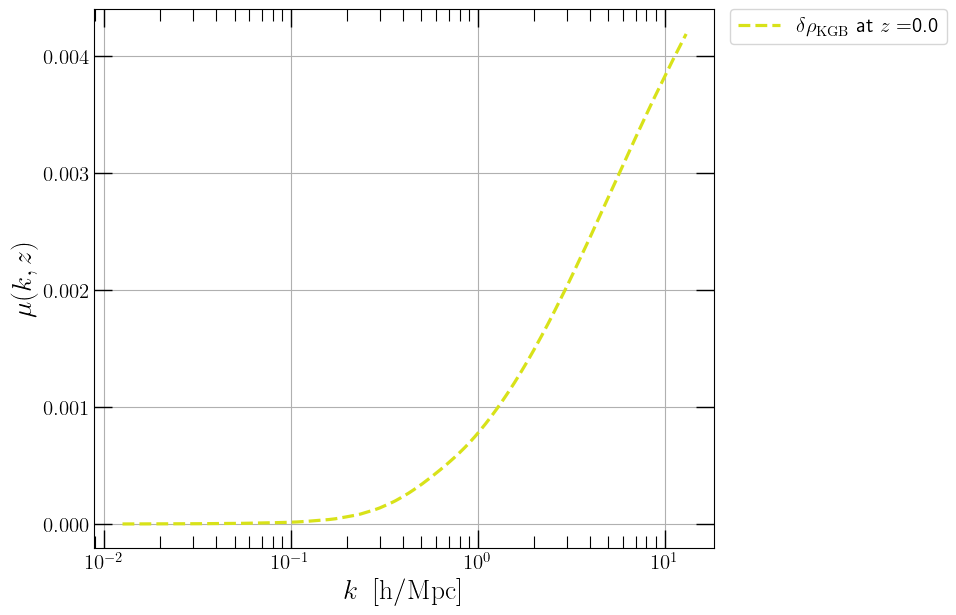

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

c = sns.color_palette("viridis", len(z)).as_hex()


################################################ plot ###########################################



###############################################################################################
#                                        hiclass KGB

axs.plot(
    kk,
    Delta_rhoDE_kgb[-1],
    linewidth=2.3,
    linestyle="--",
    c = c[zind],
    label=r"$\delta \rho_\mathrm{KGB}$  at $z = $" + "{0:.1f}".format(zval),
)



# axs.plot(
#     kk,
#     Delta_rhoDE_kess[-1],
#     linewidth=2.3,
#     linestyle="-",
#     c = c[zind],
#     label=r"$\delta \rho_\mathrm{kess}$  at $z = $" + "{0:.1f}".format(zval),
# )
    
    
 ###############################################################################################
#                                         KGB-evolution   


    

#axs.axvline(x=0.7, color='r', linestyle='--', linewidth=2)    
axs.set_ylabel(r"$\mu(k,z)$", fontsize=20)
axs.set_xlabel(r"$k\,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)
# axs.axvline(x = 1.1, c = 'blue', linestyle = '--')


axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
#axs.set_yscale("log")

axs.grid()
# axs.legend(fontsize = 15)
axs.legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.2, 1.02),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


# axs.set_ylim([0.9, 1.05])

    



plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

# save_fig("mu_hiclass")

# CLASS

In [119]:
z = [100, 50, 30, 10, 6, 1, 0.5, 0]
k_pivot = 0.05
kk = np.logspace(-3, np.log10(10), 1000)  # k in h/Mpc

def a(x):
    return 1 / (1 + x)


#######################################################################################################
#                                                Newtonian

mu_phi_new = [[] for j in range(len(z))]
mu_delta_new = [[] for j in range(len(z))]

pk_m_new = [[] for j in range(len(z))]
#######################################################################################################
#                                                Synchronous

mu_phi_syn = [[] for j in range(len(z))]
mu_delta_syn = [[] for j in range(len(z))]

pk_m_syn = [[] for j in range(len(z))]

########################################################################################################


newtonian = {
    "Omega_scf": 0,
    "Omega_Lambda": 0,
    "cs2_fld": 1e-7,
    "w0_fld": -0.9,
    "h": 0.67556,
    "omega_b": 0.022032,
    "omega_cdm": 0.12038,
    "A_s": 2.215e-9,
    "n_s": 0.9619,
    "z_max_pk": 100,
    "tau_reio": 0.05430842,
    "gauge": "Newtonian",
    "output": "mTk,mPk,vTk",
    "use_ppf": "yes",
    "P_k_max_1/Mpc": 130,
}

w_fld = newtonian["w0_fld"]
synchronous = newtonian.copy()
synchronous["gauge"] = "Synchronous"

M_new = Class()
M_syn = Class()

M_new.set(newtonian)
M_syn.set(synchronous)

M_new.compute()
M_syn.compute()

h = M_new.h()

As = newtonian["A_s"]
ns = newtonian["n_s"]


backgrounds = M_new.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_fld = interp1d(backgrounds["z"], backgrounds["(.)rho_fld"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")


for zind, zi in enumerate(z):

    rho_m = rho_b(zi) + rho_cdm(zi)

    #     rho_rest = rho_tot(zi) - rho_fld(zi)

    rho_sum = rho_cdm(zi) + rho_b(zi) + rho_g(zi) + rho_ur(zi) + rho_fld(zi)

    rho_excde = rho_tot(zi) - rho_fld(zi)

    #######################################################################################################
    #                                                 newtonian

    Transfers_new = M_new.get_transfer(zi)

    delta_fld_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_fld"], kind="cubic"
    )
    theta_fld_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_fld"], kind="cubic"
    )

    ###############
    delta_b_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_b"], kind="cubic"
    )
    theta_b_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_b"], kind="cubic"
    )
    ##############

    delta_cdm_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_cdm"], kind="cubic"
    )
    theta_cdm_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_cdm"], kind="cubic"
    )
    #############

    delta_g_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_g"], kind="cubic"
    )
    theta_g_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_g"], kind="cubic"
    )

    #############
    delta_ur_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_ur"], kind="cubic"
    )
    theta_ur_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_ur"], kind="cubic"
    )
    #############

    delta_tot_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["d_tot"], kind="cubic"
    )
    phi_new = interp1d(Transfers_new["k (h/Mpc)"], Transfers_new["phi"], kind="cubic")

    phi_prime_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["phi_prime"], kind="cubic"
    )

    psi_new = interp1d(Transfers_new["k (h/Mpc)"], Transfers_new["psi"], kind="cubic")

    theta_tot_new = interp1d(
        Transfers_new["k (h/Mpc)"], Transfers_new["t_tot"], kind="cubic"
    )

    #######################################################################################################
    #                                                 synchronous

    Transfers_syn = M_syn.get_transfer(zi)

    delta_fld_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_fld"], kind="cubic"
    )
    theta_fld_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_fld"], kind="cubic"
    )
#############    
    delta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_b"], kind="cubic"
    )
    theta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_b"], kind="cubic"
    )
#############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_cdm"], kind="cubic"
    )
#############    
    delta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_g"], kind="cubic"
    )
    theta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_g"], kind="cubic"
    )
#############
    delta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_ur"], kind="cubic"
    )
    theta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_ur"], kind="cubic"
    )
#############

    delta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_tot"], kind="cubic"
    )
    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")

    theta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_tot"], kind="cubic"
    )

    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")

    phi_prime_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["phi_prime"], kind="cubic"
    )

    psi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["psi"], kind="cubic")

    for k in kk:

        Normlization = (
            2 * (np.pi**2) * As * (k ** (-3)) * (k * h / k_pivot) ** (ns - 1)
        )

        ###############################################################################################
        #                                        newtonian

        Delta_cdm_Newt = delta_cdm_new(k) + 3 * a(zi) * H(zi) * theta_cdm_new(k) / (
            (k * h) ** 2
        )

        Delta_b_Newt  = delta_b_new(k) + 3 * a(zi) * H(zi) * theta_b_new(k) / ((k * h) ** 2)

        Delta_fld_Newt  = delta_fld_new(k) + 3 * a(zi) * H(zi) * (1 + w_fld) * theta_fld_new(
            k
        ) / ((k * h) ** 2)

        Delta_g_Newt  = delta_g_new(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_g_new(k) / (
            (k * h) ** 2
        )

        Delta_ur_Newt  = delta_ur_new(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_ur_new(
            k
        ) / ((k * h) ** 2)

        Delta_total_Newt  = (
            rho_cdm(zi) * Delta_cdm_Newt 
            + rho_b(zi) * Delta_b_Newt 
            + rho_g(zi) * Delta_g_Newt 
            + rho_ur(zi) * Delta_ur_Newt 
            + rho_fld(zi) * Delta_fld_Newt 
        ) / rho_tot(zi)

        Delta_excde_Newt = (
            rho_cdm(zi) * Delta_cdm_Newt 
            + rho_b(zi) * Delta_b_Newt 
            + rho_g(zi) * Delta_g_Newt 
            + rho_ur(zi) * Delta_ur_Newt 
        ) / rho_excde

        #         #####################
        #         #       Pk_newt     #
        #         #####################

        #         pk_m_new[zind].append(Normlization * (delta_m_new**2))


        #         #####################
        #         #       mu_newt     #
        #         #####################
        
        R = 3.0 * a(zi) * H(zi) * phi_prime_new(k) + 3.0 * (
            (a(zi) * H(zi)) ** 2
        ) * psi_new(k)
        

        mu_phi_new[zind].append(
            ((k * h) ** 4)
            * (phi_new(k) ** 2)
            / (((1.5 * (a(zi) ** 2) * rho_excde) ** 2) * Delta_excde_Newt**2)
        )

        mu_delta_new[zind].append(1 + (rho_fld(zi) * Delta_fld_Newt) / (rho_excde * Delta_excde_Newt))

        ################################################################################################
        #                                     synchronous

        Delta_cdm_Sync  = delta_cdm_syn(k) 

        Delta_b_Sync = delta_b_syn(k) + 3 * a(zi) * H(zi) * theta_b_syn(k) / ((k * h) ** 2)

        Delta_fld_Sync = delta_fld_syn(k) + 3 * a(zi) * H(zi) * (1 + w_fld) * theta_fld_syn(
            k
        ) / ((k * h) ** 2)

        Delta_g_Sync = delta_g_syn(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_g_syn(
            k
        ) / ((k * h) ** 2)

        Delta_ur_Sync = delta_ur_syn(k) + 3 * a(zi) * H(zi) * (1 + 1 / 3) * theta_ur_syn(
            k
        ) / ((k * h) ** 2)

        Delta_total_Sync  = (
            rho_cdm(zi) * Delta_cdm_Sync 
            + rho_b(zi) * Delta_b_Sync 
            + rho_g(zi) * Delta_g_Sync 
            + rho_ur(zi) * Delta_ur_Sync 
            + rho_fld(zi) * Delta_fld_Sync 
        ) / rho_tot(zi)
        
        Delta_excde_Sync = (
            rho_cdm(zi) * Delta_cdm_Sync 
            + rho_b(zi) * Delta_b_Sync 
            + rho_g(zi) * Delta_g_Sync 
            + rho_ur(zi) * Delta_ur_Sync 
        ) / rho_excde




        #####################
        #       Pk_sync     #
        #####################

        #         pk_m_syn[zind].append(Normlization * (delta_m_syn**2))

        #####################
        #       mu_sync     #
        #####################
        
        mu_phi_syn[zind].append(
            ((k * h) ** 4)
            * (phi_new(k) ** 2)
            / (((1.5 * (a(zi) ** 2) * rho_excde) ** 2) * Delta_excde_Sync**2)
        )


        mu_delta_syn[zind].append(
            1 + (rho_fld(zi) * Delta_fld_Sync) / (rho_excde * Delta_excde_Sync)
        )


In [75]:
Delta_excde_Sync

-79270.00787570898

# $\mu$ function plot

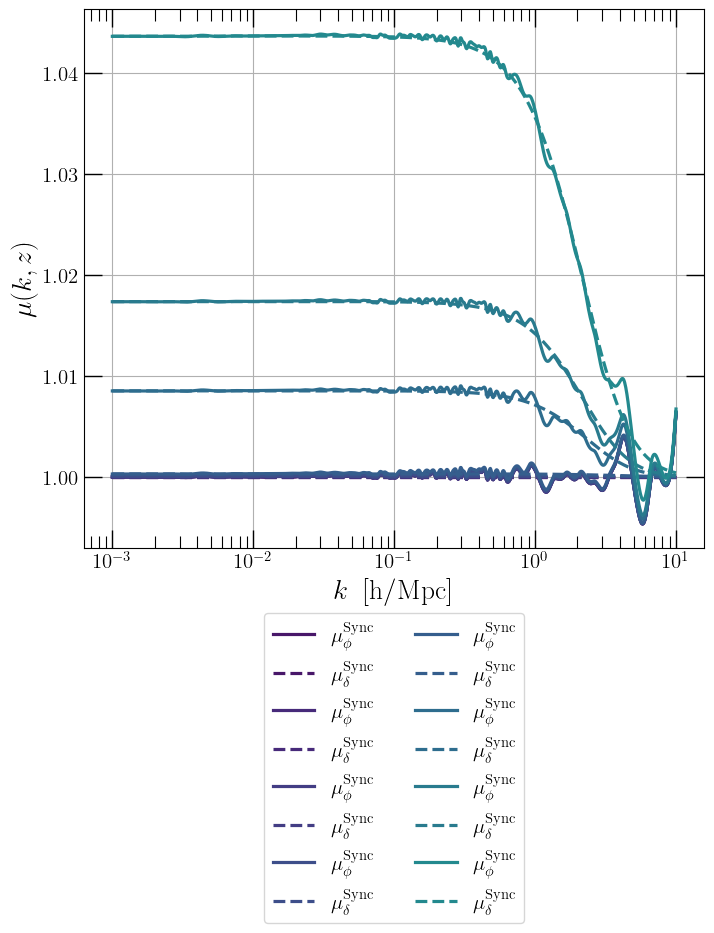

In [85]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

c = sns.color_palette("viridis", 16).as_hex()

for zind, zval in enumerate(z):
    
###############################################################################################
#                                        newtonian

#     axs.plot(
#         kk,
#         np.sqrt(mu_phi_new[zind]),
#         linewidth=2.3,
#         linestyle="-",
#         c = c[zind],
#         label="$\mu^\mathrm{Newt}_\phi$ at z = " + "{0:.1f}".format(zval),
#     )

#     axs.plot(
#         kk,
#         mu_delta_new[zind],
#         linewidth=2.3,
#         linestyle="--",
#         c = c[zind],
#         label="$\mu^\mathrm{Newt}_\delta$",
#     )
    
###############################################################################################
#                                        synchronous

    axs.plot(
        kk,
        np.sqrt(mu_phi_syn[zind]),
        linewidth=2.3,
        linestyle="-",
        c = c[zind],
        label="$\mu^\mathrm{Sync}_\phi$",
    )
    
    axs.plot(
        kk,
        mu_delta_syn[zind],
        linewidth=2.3,
        linestyle="--",
        c = c[zind],
        label="$\mu^\mathrm{Sync}_\delta$",
    )

###############################################################################################
#                                        mu poisson

#     axs.plot(
#         kk[500:],
#         mu_poisson[zind][500:],
#         linewidth=2.3,
#         linestyle="--",
#         c = c[zind],
#         label="$\mu^\mathrm{Sync}_\phi$ at z = " + "{0:.1f}".format(zval),
#     )
    
axs.set_ylabel(r"$\mu(k,z)$", fontsize=20)
axs.set_xlabel(r"$k\,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)
# axs.axvline(x = 1.1, c = 'blue', linestyle = '--')


axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
#axs.set_yscale("log")

axs.grid()
# axs.legend(fontsize = 15)
axs.legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(0.5, -0.1),  # Position outside plot area (x, y relative to axes)
    ncol=2,  # Number of columns
)

#axs.set_xlim([1.0e-5, 60])

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

$$
\mu(k,z)^2 = \frac{k^4<\Phi \Phi^*>}{(4\pi G_N a^2\bar\rho_\mathrm{tot})^2<\delta_\mathrm{tot}\delta_\mathrm{tot}^*>}
$$

$$
\mu(k,z)^2 = \frac{k^4<\Phi \Phi^*>}{(4\pi G_N a^2\bar\rho_\mathrm{m})^2<\delta_\mathrm{m}\delta_\mathrm{m}^*>}
$$